# Notebook 02: EDA

## Contents:
1. [Summary](#section1)
2. [Dropping or Amending Lyrics](#section2)
3. [Cleaning Lyrics](#section3)
4. [Song Structure Analysis](#section4)
5. [Plotting](#section5)
6. [Lyric Structure Analysis](#section6)

## Summary  <a name="section1"></a>
This notebook contains cleaning and exploration of the dataset with the goal of identifying any underlying trends and preparing the data for modeling. Text will be normalized and song structure will be reviewed.

Importing necessary libraries.

In [4]:
import json, time, re, requests, pickle
import pandas as pd
import psycopg2 as pg2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import plotly
import plotly.plotly as py
import plotly.graph_objs as go

from psycopg2.extras import RealDictCursor, Json
from psycopg2.extensions import AsIs

%matplotlib inline
plt.style.use('fivethirtyeight')

%run ../assets/sql_cred.py
%run ../assets/plotly_cred.py

Submitting credentials for access to the Plotly API.

In [5]:
plotly.tools.set_credentials_file(username=USERNAME, api_key=API_KEY)

Defining a helper function for saving out files with timestamping and file logging.

In [6]:
def filename_format_log(file_path, 
                        logfile = '../assets/file_log.txt', 
                        now = round(time.time()), 
                        file_description = None): 
   
    try:
        ext = re.search('(?<!^)(?<!\.)\.(?!\.)', file_path).start() 
    except:
        raise NameError('Please enter a relative path with a file extension.') 
    
    stamp = re.search('(?<!^)(?<!\.)[A-z]+_[0-z]+(?=\.)', file_path).start()
    formatted_name = f'{file_path[:stamp]}{now}_{file_path[stamp:]}'  
    if not file_description:
        file_description = f'Saved at: {time.asctime(time.gmtime(now))}'
    with open(logfile, 'a+') as f:
        f.write(f'{formatted_name}: {file_description}\n')
    return formatted_name, now, file_description

Reusing the SQL helper functions for database querying the track_list db

In [7]:
def con_cur_to_db(dbname=DBNAME, dict_cur=None):
    con = pg2.connect(host=IP_ADDRESS,
                  dbname=dbname,
                  user=USER,
                  password=PASSWORD)
    if dict_cur:
        cur = con.cursor(cursor_factory=RealDictCursor)
    else:
        cur = con.cursor()
    return con, cur
    
def execute_query(query, dbname=DBNAME, dict_cur=None, command=False):
    con, cur = con_cur_to_db(dbname, dict_cur)
    cur.execute(f'{query}')
    if not command:
        data = cur.fetchall()
        con.close()
        return data
    con.commit() #sends to server
    con.close() #closes server connection

In [8]:
query = '''SELECT * FROM track_list;'''
response = execute_query(query, dict_cur=True)
track_df = pd.DataFrame(response)
track_df.set_index('track_id', inplace=True)
track_df.head()

,album_name,artist_name,lyrics,playlist_id,playlist_name,playlist_owner,track_name
track_id,,,,,,,
0h7TlF8gKb61aSm874s3cV,I Can't Tell You How Much It Hurts,moow,\n\nIf your needle is near\nNeedle is near\nYo...,37i9dQZF1DXarebqD2nAVg,Tender,spotify,You'r in My Head
6koowTu9pFHPEcZnACLKbK,Coming Home,Leon Bridges,\n\n[Verse 1]\nBrown skin girl on the other si...,37i9dQZF1DX4adj7PFEBwf,Wedding Bells,spotify,Brown Skin Girl
1JkhKUXAoNivi87ipmV3rp,Back To Love (Deluxe Version),Anthony Hamilton,"\n\n[Verse 1]\nIt's simple, I love it\nHaving ...",37i9dQZF1DX4adj7PFEBwf,Wedding Bells,spotify,Best of Me
51lPx6ZCSalL2kvSrDUyJc,The Search for Everything,John Mayer,\n\n[Intro: Whistling]\n\n[Verse 1]\nA great b...,37i9dQZF1DX4adj7PFEBwf,Wedding Bells,spotify,You're Gonna Live Forever in Me
3vqlZUIT3rEmLaYKDBfb4Q,Songs In The Key Of Life,Stevie Wonder,\n\n[Verse 1]\nIsn't she lovely\nIsn't she won...,37i9dQZF1DX4adj7PFEBwf,Wedding Bells,spotify,Isn't She Lovely


Saving out the lyrics column in a separate dataframe for cleaning and analysis

In [9]:
lyric_df = track_df[['lyrics']]

Checking shape before cleaning.

In [10]:
lyric_df.shape

(2861, 1)

## Dropping or Amending Lyrics <a name="section2"></a>

Dropping or appending tracks that have been identified below as having errors such as non-song text, non-english text, missing tags, long whitespace gaps, etc prior to cleaning.

Dropping any null values.

In [11]:
lyric_df = lyric_df.dropna(axis=0)

Not english

In [12]:
lyric_df = lyric_df.drop(index='1mjWhM7GQTTxJxg2F0iCRS', axis=0)

In [13]:
lyric_df = lyric_df.drop(index='4tjLYTXFqZhkUDga4bQ0yl', axis=0)

In [14]:
lyric_df = lyric_df.drop(index='2za6PlkAQAMMu0VFsfBoHC', axis=0)

In [15]:
lyric_df = lyric_df.drop(index='0CNKS52qyUU9124pyENtbl', axis=0)

In [16]:
lyric_df = lyric_df.drop(index='7Mfb2IwRNP8Qi7Ojtpmi37', axis=0)

In [79]:
lyric_df = lyric_df.drop(index='53l6zTxcgzRMAgD3eS6zqF', axis=0)

Missing ']' creating a tagging error.

In [17]:
lyric_df.loc['1Ob94QesoxHSBrypyBbdfd', 'lyrics'] = "\n\n[Verse 1]\nWe've been here before, surrounded in the cold\nYou take me to places I've never known\nAnd you push me to places I'll never go\nI would die for you\nTell me the truth\nAm I all that you would need?\nIf we're keeping it a hundred, you're all that I need for me\nFrom the jump until forever from now, I would ride for you\n\n[Chorus]\nBut you got me shot down by love\nYou got my heart now\nWhy won't you stop now?\nOh I've been knocked down by you\nYou got my heart now\nWhy won't you stop now?\n\n[Verse 2]\nI've been through it whole\nI've been through the worst\nBut I never knew how much our love could hurt\nOver my family I put you first\nWriting out my feelings is the only thing that work\nI don't hear from the friends I thought were mine too\nBut I hold on to the poems I would write you\nHappy seventeen, I saw us two and you saw three\nI guess our lines are structured like a haiku\n\n[Chorus 2]\nYou got me shot down by love\nAnd you got my heart now\nWhy won't you stop now?\nOh I've been knocked down by you\nAnd you got my heart now\nWhy won't you stop now?\n\n[Bridge]\nKnocked down, knocked down\nKnocked down, knocked down\nKnocked down\nKnocked down\n\n[Chorus]\nI've been shot down by love\nYou got my heart now\nWhy won't you stop now?\nI've been knocked down by you\nAnd you got my heart now\nWhy won't you stop now?\n\n"

Tracks identified by having too few total lines per track.

In [18]:
lyric_df.loc['2Wu9PNpLUCBl3W1GaPqkhl'].lyrics

'\n\nMorni Banke (Badhaai Ho) Guru Randhawa Neha Kakkar 320kbps Mp3 Songs Download, Morni Banke (Badhaai Ho) Guru Randhawa Neha Kakkar 320kbps iTunes Rip Mp3 Songs Download, Morni Banke (Badhaai Ho) Guru Randhawa Neha Kakkar 320kbps 128 Kbps Mp3 Songs Free Download, Morni Banke (Badhaai Ho) Guru Randhawa Neha Kakkar 320kbps 320 Kbps Mp3 Songs Free Download, Morni Banke (Badhaai Ho) Guru Randhawa Neha Kakkar 320kbps Mp3 Songs Download In High Quality, Morni Banke (Badhaai Ho) Guru Randhawa Neha Kakkar 320kbps Mp3 Songs Download 320kbps Quality, Morni Banke (Badhaai Ho) Guru Randhawa Neha Kakkar 320kbps Mp3 Songs Download, Morni Banke (Badhaai Ho) Guru Randhawa Neha Kakkar 320kbps All Mp3 Songs Download, Morni Banke (Badhaai Ho) Guru Randhawa Neha Kakkar 320kbps Full Songs Download\n\n'

In [19]:
lyric_df = lyric_df.drop(index='2Wu9PNpLUCBl3W1GaPqkhl', axis=0)

Mislabed lyrics with '\n\n' for linebreaks

In [20]:
lyric_df.loc['6xYd4zCVeSp80Un2Rl9wDs'].lyrics

"\n\nBaby let's cruise away from here\n\nDon't be confused baby, the way is clear\n\nAnd if you want it you got it forever\n\nOh, this is not a one night stand baby\n\nLet the music take your mind\n\nAnd just release and you will find, baby\n\nWe're going to fly away\n\nGlad you're going my way\n\nI love it when we're cruisin' together\n\nMusic was made for love\n\nCruisin' is made for love\n\nI love it when we're cruisin' together\n\nBaby, tonight belongs to us\n\nEverything's right, do what you must, baby\n\nAnd inch by inch we get closer and closer\n\nEvery little part of each other ooh, baby, baby\n\nLet the music take your mind\n\nJust release and you will find, baby\n\nWe're going to fly away\n\nGlad you're going my way\n\nI love it when we're cruisin' together\n\nMusic was made for love\n\nCruisin' is made for love\n\nI love you when we're cruisin' together\n\nWe're going to fly away\n\nGlad you're going my way\n\nI love it when we're cruisin' together\n\nMusic was made for love

In [21]:
lyric_df.loc['6xYd4zCVeSp80Un2Rl9wDs', 'lyrics'] = lyric_df.loc['6xYd4zCVeSp80Un2Rl9wDs'].lyrics.replace('\n\n','\n')

In [22]:
lyric_df.loc['6XkChVvxj0Cakfae17NaK3'].lyrics

'\n\nI ran into a woman on the sidewalk\n\n‘cause I was thinking too much about us\n\nDreaming of you and all we’ve lost\n\n‘Cause now you’re always so angry\n\nYou’re always so sad\n\nYou’re mad about everything and everyone and I\n\nI don’t have the heart for that\n\nHow we used to love\n\nI’m afraid for our future\n\nI’m afraid it won’t last\n\n‘Cause you’ve got too many scars to hide\n\nAnd I haven’t got enough to understand why\n\nWhy are you always so sad\n\nWhy are you always so\n\nWhy are you always so sad?\n\nHow we used to love\n\nHow we used to love\n\nHow we used to love\n\nHow we used to love\n\n'

In [23]:
lyric_df.loc['6XkChVvxj0Cakfae17NaK3', 'lyrics']= lyric_df.loc['6XkChVvxj0Cakfae17NaK3'].lyrics.replace('\n\n','\n')

In [24]:
lyric_df.loc['5ONPeQRp1m4KJ0M57qBj1D'].lyrics

"\n\nShe was too good to me\nShe was too good to me\n\nHow can I get along now\n\nSo close she stood to me\n\nEverything seems so wrong now\n\nShe would have brought me the sun\n\nMaking me smile\n\nThat was her fun\n\nWhen I was mean to her\n\nShe never said go away now\n\nI was a king to her\n\nWho's gonna make me gay now?\n\nIt's only natural\n\nI'm so blue\n\nShe was too good to be true\n\n"

In [25]:
lyric_df.loc['5ONPeQRp1m4KJ0M57qBj1D', 'lyrics'] = lyric_df.loc['5ONPeQRp1m4KJ0M57qBj1D'].lyrics.replace('\n\n','\n')

Not a song

In [26]:
lyric_df.loc['44z4AP1yhEjcbihu5qdXsZ'].lyrics

'\n\nTo Noel Willmett\n\n18 May 1944\n10a Mortimer Crescent NW 6\n\nDear Mr Willmett,\n\nMany thanks for your letter. You ask whether totalitarianism, leader-worship etc. are really on the up-grade and instance the fact that they are not apparently growing in this country and the USA.\n\nI must say I believe, or fear, that taking the world as a whole these things are on the increase. Hitler, no doubt, will soon disappear, but only at the expense of strengthening (a) Stalin, (b) the Anglo-American millionaires and (c) all sorts of petty fuhrers° of the type of de Gaulle. All the national movements everywhere, even those that originate in resistance to German domination, seem to take non-democratic forms, to group themselves round some superhuman fuhrer (Hitler, Stalin, Salazar, Franco, Gandhi, De Valera are all varying examples) and to adopt the theory that the end justifies the means. Everywhere the world movement seems to be in the direction of centralised economies which can be made 

In [27]:
lyric_df = lyric_df.drop(index='44z4AP1yhEjcbihu5qdXsZ', axis=0)

In [28]:
lyric_df.loc['0cqSEpg2nYbneh7RGNrDcp'].lyrics

'\n\nToday I entered a bill to end the states involvement in the sanctioning of marriage. Right now, as it sits with the decision from our U.S. Supreme Court looming, our elected officials could be forced to perform same sex marriages; if this happens then the liberal left will use this Supreme Court decision as a hammer to advance their liberal agenda. If the Supreme Court surprises everyone and decides to uphold the institution of marriage then I will simply will have the option to then withdraw the bill. The winds of secular progressivism gives me the sense that our Supreme Court is handing us their next step in the end of traditional morality for America. This bill simply put will end our elected official’s involvement in performing marriage ceremonies.\n\nIt is incredibly important that if the Supreme Court rules against traditional marriage that our elected officials are not forced to violate their conscience and be forced to perform gay marriages. Further note on another piece o

In [29]:
lyric_df = lyric_df.drop(index='0cqSEpg2nYbneh7RGNrDcp', axis=0)

In [30]:
lyric_df.head()

,lyrics
track_id,
0h7TlF8gKb61aSm874s3cV,\n\nIf your needle is near\nNeedle is near\nYo...
6koowTu9pFHPEcZnACLKbK,\n\n[Verse 1]\nBrown skin girl on the other si...
1JkhKUXAoNivi87ipmV3rp,"\n\n[Verse 1]\nIt's simple, I love it\nHaving ..."
51lPx6ZCSalL2kvSrDUyJc,\n\n[Intro: Whistling]\n\n[Verse 1]\nA great b...
3vqlZUIT3rEmLaYKDBfb4Q,\n\n[Verse 1]\nIsn't she lovely\nIsn't she won...


## Cleaning Lyrics <a name="section3"></a>

Defining a helper function to clean and split the lyrics to prepare for modeling. '\n' characters will be preserved to allow the model to train on song structure however all tags and special characters (non-alphanumaric) will be removed.

In [31]:
def clean_lyrics(lyrics, keep_tags=False, keep_nl=False):

    text = lyrics.lower()

    if not keep_tags:
        text = re.sub('(\[.+\])', '', text)

    text = re.sub('[^a-z\s]', '', text)

    text = text.strip()
    text = re.sub('\n\n', ' ', text) 

    text = text.strip()

    if keep_nl:
        text = re.sub('\n', ' \n ', text)
    else:
        text = re.sub('\n', ' ', text)


    return text

Applying the cleaning function with a 'clean_lyrics' feature created as the output.

In [32]:
lyric_df['clean_lyrics'] = lyric_df.lyrics.map(lambda x: clean_lyrics(x, keep_tags=False, keep_nl=True))

In [33]:
lyric_df.head()

,lyrics,clean_lyrics
track_id,,
0h7TlF8gKb61aSm874s3cV,\n\nIf your needle is near\nNeedle is near\nYo...,if your needle is near \n needle is near \n yo...
6koowTu9pFHPEcZnACLKbK,\n\n[Verse 1]\nBrown skin girl on the other si...,brown skin girl on the other side of the room ...
1JkhKUXAoNivi87ipmV3rp,"\n\n[Verse 1]\nIt's simple, I love it\nHaving ...",its simple i love it \n having you near me hav...
51lPx6ZCSalL2kvSrDUyJc,\n\n[Intro: Whistling]\n\n[Verse 1]\nA great b...,a great big bang and dinosaurs \n fiery rainin...
3vqlZUIT3rEmLaYKDBfb4Q,\n\n[Verse 1]\nIsn't she lovely\nIsn't she won...,isnt she lovely \n isnt she wonderful \n isnt ...


Searching for any tracks that are spanish or french. Since this will not represent the bulk of the dataset and generally will not be mixed with english they will be removed.

In [36]:
not_eng = lyric_df[lyric_df['clean_lyrics'].str.contains('(\sdel\s)|(\sque\s)|(\svous\s)|(\setre\s)')].index.tolist()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning:

This pattern has match groups. To actually get the groups, use str.extract.



In [35]:
lyric_df = lyric_df.drop(index=not_eng, axis=0)

Removing any tracks that have a Genius status stating that 'lyrics for the track have not yet been added'.

In [37]:
not_lyrics = lyric_df[lyric_df['clean_lyrics'].str.contains('lyrics for this song have yet')].index.tolist()

In [38]:
lyric_df = lyric_df.drop(index=not_lyrics, axis=0)

Removing any tracks with long stretches of whitespace characters.

In [39]:
long_gap = lyric_df[lyric_df['clean_lyrics'].str.contains(r'(\s{6,})')].index.tolist()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning:

This pattern has match groups. To actually get the groups, use str.extract.



In [40]:
lyric_df = lyric_df.drop(index=long_gap, axis=0)

Removing any duplicate tracks.

In [41]:
lyric_df = lyric_df.drop_duplicates(subset=['clean_lyrics'])

In [42]:
lyric_df.describe()

,lyrics,clean_lyrics
count,1782,1782
unique,1782,1782
top,\n\n[Chorus]\nI can feel it coming in the air ...,one two three four \n i just want you close \...
freq,1,1


From the data description it appears that all our tracks are unique and there is parity between the lyrics and clean_lyrics features.

## Song Structure Analysis <a name="section4"></a>

To direct model development, it will be important to understand the structure of a song. Here, I will analyze word repetition, word count, song length, line length, and other structural features. 

Here, I define a helper function inspired by Rick Wicklin [(source)](https://blogs.sas.com/content/iml/2018/03/14/visualize-repetition-lyrics.html) that helps visualize word repetition within a track. Each word makes up a row within the matrix and if the word is repeated the cell is filled in. As we can see, tracks have wide variation not just in word length, but also in word repetition.

In [43]:
def lyrics_grid(track, df=lyric_df):
#     track = df.loc[track_id, 'clean_lyrics']
    
    lyrics_spaced = re.sub(r'( +)', ' ', track)
    lyrics_spaced = re.sub(r'\n ', '', lyrics_spaced)
    lyrics_split = lyrics_spaced.split(' ')
    
    N = len(lyrics_split)
    grid = np.zeros(shape=(N,N), dtype='int')
    
    for i in range(N):
        hits = [j for j, word in enumerate(lyrics_split) if word == lyrics_split[i]]
        grid[i,[hits]] = 1 
        
    plt.title('Repetition in Track');
    plt.xlabel('Word Number');
    plt.ylabel('Word Number');
    sns.heatmap(grid, cmap='Greys', cbar=False, xticklabels=[], yticklabels=[]);
    
    plt.show();
    
    rep_ratio = np.around(((N - len(set(lyrics_split))) / N), 2)
    
    print('\n')
    print(f'The repetition ratio for this track is {rep_ratio}')
    print('\n')
    print(track)
    return 

In [44]:
lyric_df.clean_lyrics.iloc[0]

'if your needle is near \n needle is near \n you can take my blood \n oh i saved it for you \n hundreds of drops \n running red needle is near \n you can take my blood \n oh i saved it for you \n hundreds of drops \n running red \n needle is near \n oh i saved it for you \n hundreds of drops \n running red'

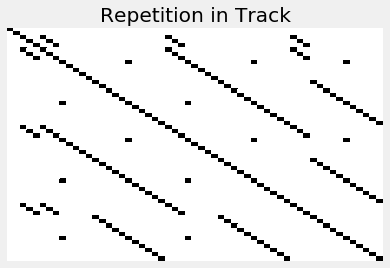



The repetition ratio for this track is 0.65


if your needle is near 
 needle is near 
 you can take my blood 
 oh i saved it for you 
 hundreds of drops 
 running red needle is near 
 you can take my blood 
 oh i saved it for you 
 hundreds of drops 
 running red 
 needle is near 
 oh i saved it for you 
 hundreds of drops 
 running red


In [45]:
lyrics_grid(lyric_df.clean_lyrics.iloc[0])

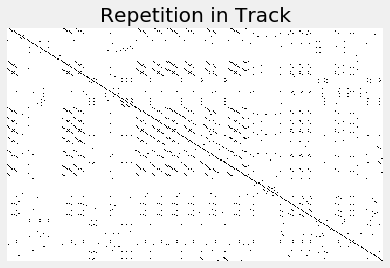



The repetition ratio for this track is 0.64


its so good lovin somebody 
 when somebody loves you back  
 to be loved and be loved in return 
 its the only thing that my heart desires 
 just appreciate the little things i do 
 oh youre the one whos got me inspired 
 keep on liftin liftin me higher  
 so good good lovin somebody 
 when somebody loves you back 
 its so good needin somebody 
 when somebody needs you back  
 we can build a world of love a life of joy 
 make our goal each others happiness 
 i will do for you anything that i can 
 oh everyday i wanna do a little more 
 do a little more just a little bit more  
 its so good lovin somebody 
 when somebody loves you back and thats a fact 
 its so good wantin somebody 
 when somebody wants you back 
 said its so good   
 so good lovin somebody 
 when somebody loves you back and thats a fact 
 its so good needin somebody 
 when somebody needs you back  
 said not  
 not  
 talkin bout a  love  
 said its so good lovin somebody

In [46]:
lyrics_grid(lyric_df.clean_lyrics.iloc[5])

While the two tracks shown above share a similar word repetition rate they exhibit vastly different song structures. The second track has many more lines as well as a much larger vocabulary, producing a much more intrecate repetition matrix.

The code below will iterate through the tracklist to produce raw word lists for analysis. Lists of interests are a full corpus, a list of words in each track, and a list of lines in each track. With these lists as a starting point, I will also look at raw counts for each structural unit.

In [47]:
corpus = []
words_track = []    
lines_track = []

for _, track in lyric_df[['clean_lyrics']].iterrows():
    #words in full set
    lyrics = track[0]
    lyrics_spaced = re.sub(r'( +)', ' ', lyrics)
    lyrics_split = lyrics_spaced.split(' ')
    corpus.extend(lyrics_split)
    
    #lines in track
    lines_split = lyrics_spaced.split('\n')
    lines_track.append(lines_split)
    
    #words in track w/o \n 
    lyrics_spaced = re.sub(r'\n ', '', lyrics_spaced)
    lyrics_split = lyrics_spaced.split(' ')
    words_track.append(lyrics_split)

Total words in the dataset

In [48]:
len(corpus)

574267

Mean number of words per track

In [49]:
len(corpus)/lyric_df.shape[0]

322.25982042648707

Total unique words in the dataset

In [50]:
vocab = set(list(corpus))
len(vocab)

12334

Mean word length in dataset

In [51]:
len_word = 0
for word in vocab:
    len_word += len(word)

In [52]:
mean_len_word = len_word / len(vocab)
mean_len_word

6.373439273552781

Mean number of unique words per track

In [53]:
len(vocab)/lyric_df.shape[0]

6.921436588103255

Total words per track

In [54]:
count_words_track = []
for i in words_track:
    count_words_track.append(len(i))
    
lyric_df['total_words_track'] = count_words_track

Unique words per track

In [55]:
unique_words_track = []
for track in words_track:
    unique_words_track.append(set(track))

In [56]:
count_unique_words_track = []
for track in unique_words_track:
    count_unique_words_track.append(len(track))
    
lyric_df['unique_words_track'] = count_unique_words_track

In [57]:
lyric_df['unique_words_track'] = count_unique_words_track

Mean word length per track

In [58]:
len_words_track = []
for i in words_track:
    len_words = []
    for word in i:
        len_words.append(len(word))
    len_words_track.append(np.around(np.mean(len_words),1))
    
lyric_df['mean_len_words_track'] = len_words_track

Total lines per track

In [59]:
count_lines_track = []
for i in lines_track:
    count_lines_track.append(len(i))
    
lyric_df['total_lines_track'] = count_lines_track

Unique lines per track

In [60]:
unique_lines_track = []
for track in lines_track:
    unique_lines_track.append(set(track))

In [61]:
count_unique_lines_track = []
for track in unique_lines_track:
    count_unique_lines_track.append(len(track))
    
lyric_df['unique_lines_track'] = count_unique_lines_track

Mean lines for track in dataset

In [62]:
np.mean(count_lines_track)

40.778338945005615

Mean words per line

In [63]:
mean_words_line = []
for track in lines_track:
    words_line = []
    for line in track:
        words_line.append(len(line.split(' ')))
    mean_words_line.append(np.around(np.mean(words_line),1))
    
lyric_df['mean_words_line'] = mean_words_line

Mean Unique words per line

In [64]:
mean_unique_words_line = []
for track in lines_track:
    unique_words_line = []
    for line in track:
        unique_words_line.append(len(set(line.split(' '))))
    mean_unique_words_line.append(np.around(np.mean(unique_words_line),1))

lyric_df['mean_unique_words_line'] = mean_unique_words_line

In [65]:
lyric_df.head()

,lyrics,clean_lyrics,total_words_track,unique_words_track,mean_len_words_track,total_lines_track,unique_lines_track,mean_words_line,mean_unique_words_line
track_id,,,,,,,,,
0h7TlF8gKb61aSm874s3cV,\n\nIf your needle is near\nNeedle is near\nYo...,if your needle is near \n needle is near \n yo...,57,20,3.7,14,8,5.9,5.1
6koowTu9pFHPEcZnACLKbK,\n\n[Verse 1]\nBrown skin girl on the other si...,brown skin girl on the other side of the room ...,132,52,4.1,24,13,7.4,5.8
1JkhKUXAoNivi87ipmV3rp,"\n\n[Verse 1]\nIt's simple, I love it\nHaving ...",its simple i love it \n having you near me hav...,151,63,4.2,29,21,7.1,5.8
51lPx6ZCSalL2kvSrDUyJc,\n\n[Intro: Whistling]\n\n[Verse 1]\nA great b...,a great big bang and dinosaurs \n fiery rainin...,126,76,4.0,20,18,8.2,7.2
3vqlZUIT3rEmLaYKDBfb4Q,\n\n[Verse 1]\nIsn't she lovely\nIsn't she won...,isnt she lovely \n isnt she wonderful \n isnt ...,108,66,4.1,21,20,7.0,6.1


## Plotting <a name="section5"></a>

Leveraging the counts from the previous section, I will plot out distributions to better understand how these features compare across the dataset. These plots may also be used as a frameword to help build out an interactive data dashboard which allows the user of the song generator to visualize song structure.

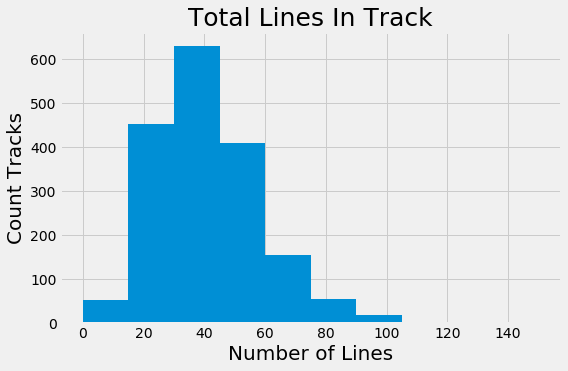

In [66]:
plt.figure(figsize=(8,5));
plt.title('Total Lines In Track', fontsize=25);
plt.xlabel('Number of Lines', fontsize=20);
plt.ylabel('Count Tracks', fontsize=20);
plt.hist(lyric_df['total_lines_track'], range=(0,150));

This histogram shows that most of the tracks have between 30-45 lines.

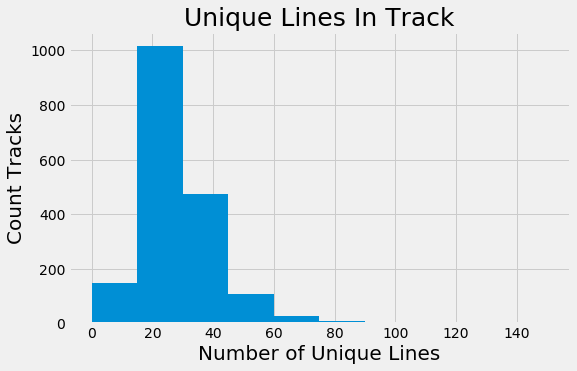

In [68]:
plt.figure(figsize=(8,5));
plt.title('Unique Lines In Track', fontsize=25);
plt.xlabel('Number of Unique Lines', fontsize=20);
plt.ylabel('Count Tracks', fontsize=20);
plt.hist(lyric_df['unique_lines_track'], range=(0,150));

This histogram shows that the majority of the tracks have between 18-35 unique lines.

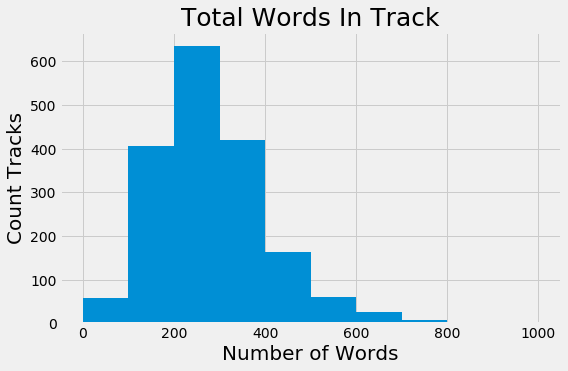

In [69]:
plt.figure(figsize=(8,5));
plt.title('Total Words In Track', fontsize=25);
plt.xlabel('Number of Words', fontsize=20);
plt.ylabel('Count Tracks', fontsize=20);
plt.hist(lyric_df['total_words_track'], range=(0, 1000));

This histogram shows that most tracks in the dataset have between 200-300 words. This will is useful for determining a reasonable number of words for the model to generate.

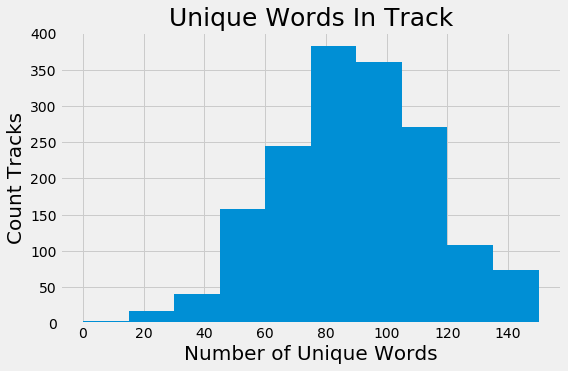

In [70]:
plt.figure(figsize=(8,5));
plt.title('Unique Words In Track', fontsize=25);
plt.xlabel('Number of Unique Words', fontsize=20);
plt.ylabel('Count Tracks', fontsize=20);
plt.hist(lyric_df['unique_words_track'], range=(0,150));

This histogram shows that most tracks have between 70-110 unique words, giving some additional insight into word repetition.

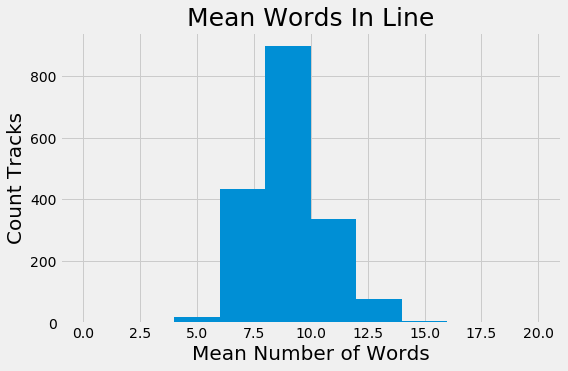

In [71]:
plt.figure(figsize=(8,5));
plt.title('Mean Words In Line', fontsize=25);
plt.xlabel('Mean Number of Words', fontsize=20);
plt.ylabel('Count Tracks', fontsize=20);
plt.hist(lyric_df['mean_words_line'], range=(0,20));

Across the dataset, the mean number of words per line is between 8-10.

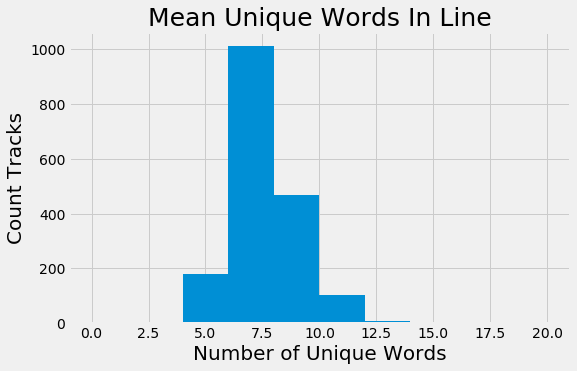

In [72]:
plt.figure(figsize=(8,5));
plt.title('Mean Unique Words In Line', fontsize=25);
plt.xlabel('Number of Unique Words', fontsize=20);
plt.ylabel('Count Tracks', fontsize=20);
plt.hist(lyric_df['mean_unique_words_line'], range=(0,20));

The vast majority of tracks feature around 5.5-8 unique words per line.

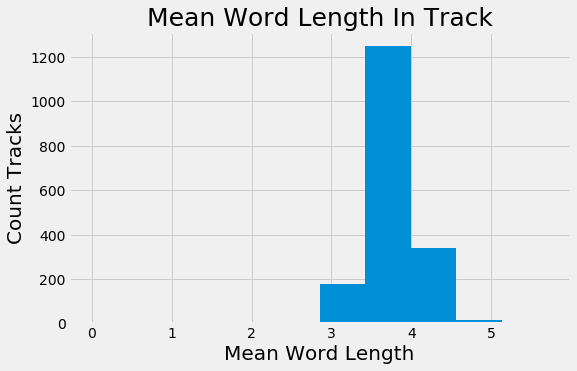

In [73]:
plt.figure(figsize=(8,5));
plt.title('Mean Word Length In Track', fontsize=25);
plt.xlabel('Mean Word Length', fontsize=20);
plt.ylabel('Count Tracks', fontsize=20);
plt.hist(len_words_track);

The average word length is between 3.5-4 for most tracks in the dataset.

Creating Histogram overlays to directly compare total vs unique song features.

In [74]:
trace1 = go.Histogram(
    x=lyric_df['total_words_track'],
    opacity=0.75,
    hoverinfo=['x'],
    name='Total Words',
    xbins=dict(
        start=0,
        end=1400,
        size=20
    ),
)
trace2 = go.Histogram(
    x=lyric_df['unique_words_track'],
    opacity=0.75,
    hoverinfo=['x'],
    name='Unique Words',
    xbins=dict(
        start=0,
        end=1400,
        size=20
    ),
)

data = [trace1, trace2]
layout = go.Layout(barmode='overlay',
                   title='Total vs Unique Words in Track',
                   xaxis=dict(
                            title='Words in Track'
                            ),
                   yaxis=dict(
                            title='Count Tracks')
                  )

fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='words_overlay', auto_open=True)

/opt/conda/lib/python3.6/site-packages/IPython/core/display.py:689: UserWarning:

Consider using IPython.display.IFrame instead



The Total vs Unique Words in Track plot shows a much wider spread for total words, as would be expected. There are also some significant outliers with > 800 words for the entire track, while unique words tend to be much more consistent in distribution.

In [75]:
trace1 = go.Histogram(
    x=lyric_df['mean_words_line'],
    opacity=0.75,
    hoverinfo=['x'],
    name='Total Words',
    xbins=dict(
        start=0,
        end=50,
        size=1
    ),
)
trace2 = go.Histogram(
    x=lyric_df['mean_unique_words_line'],
    opacity=0.75,
    hoverinfo=['x'],
    name='Unique Words',
    xbins=dict(
        start=0,
        end=50,
        size=1
    ),
)

data = [trace1, trace2]
layout = go.Layout(barmode='overlay',
                   title='Total vs Unique Words in Line',
                   xaxis=dict(
                            title='Mean Words in Line'
                            ),
                   yaxis=dict(
                            title='Count Tracks')
                   
                  )

fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='mean_words_overlay', auto_open=True)

/opt/conda/lib/python3.6/site-packages/IPython/core/display.py:689: UserWarning:

Consider using IPython.display.IFrame instead



Mean vs Unique Words in Line are virtually identical. Since there are so few words to a line, this is largely unsurprising.

In [76]:
trace1 = go.Histogram(
    x=lyric_df['total_lines_track'],
    opacity=0.75,
    hoverinfo=['x'],
    name='Total Lines',
    xbins=dict(
        start=0,
        end=250,
        size=10
    ),
)
trace2 = go.Histogram(
    x=lyric_df['unique_lines_track'],
    opacity=0.75,
    hoverinfo=['x'],
    name='Unique Lines',
    xbins=dict(
        start=0,
        end=250,
        size=10
    ),
)

data = [trace1, trace2]
layout = go.Layout(barmode='overlay',
                   title='Total vs Unique Lines in Track',
                   xaxis=dict(
                            title='Lines in Track'
                            ),
                  yaxis=dict(
                            title='Count Tracks')
                  )

fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='lines_overlay', auto_open=True)

High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~csinatra/0 or inside your plot.ly account where it is named 'lines_overlay'


/opt/conda/lib/python3.6/site-packages/IPython/core/display.py:689: UserWarning:

Consider using IPython.display.IFrame instead



The Total vs Unique Words in track show similar distributions with the unique lines shifted by about 10. The vast majority of tracks have between 30-40 unique lines.

Reviewing summary statistics for the numeric features.

In [83]:
lyric_df.describe().T

,count,mean,std,min,25%,50%,75%,max
total_words_track,1781.0,282.639528,125.380335,13.0,195.0,267.0,346.0,1339.0
unique_words_track,1781.0,96.058956,37.770647,5.0,74.0,92.0,112.0,433.0
mean_len_words_track,1781.0,3.748175,0.264051,2.8,3.6,3.7,3.9,5.7
total_lines_track,1781.0,40.800674,17.889364,1.0,28.0,38.0,51.0,224.0
unique_lines_track,1781.0,27.646828,12.112090,1.0,20.0,25.0,33.0,189.0
mean_words_line,1781.0,9.069175,2.031524,4.2,7.9,8.8,9.9,55.4
mean_unique_words_line,1781.0,7.585345,1.677593,3.6,6.6,7.4,8.3,39.8


Some standout statistics are a min total_words_track and total_lines_track of 1, suggesting this may be some data errors. 

Reviewing tracks with fewer than 5 lines.

In [80]:
lyric_df[lyric_df.loc[:,'total_lines_track'] < 5]

,lyrics,clean_lyrics,total_words_track,unique_words_track,mean_len_words_track,total_lines_track,unique_lines_track,mean_words_line,mean_unique_words_line
track_id,,,,,,,,,
4usvynbYaFqgm4olpzEp9u,"\n\nYou have to take a little, give a little, ...",you have to take a little give a little and le...,26,19,3.7,1,1,26.0,19.0


In [81]:
lyric_df.loc['4usvynbYaFqgm4olpzEp9u'].lyrics

'\n\nYou have to take a little, give a little, and let your cold heart break a little. thats the story of thats the glory of love\n\n'

In [82]:
lyric_df[lyric_df.loc[:,'total_words_track'] < 5]

,lyrics,clean_lyrics,total_words_track,unique_words_track,mean_len_words_track,total_lines_track,unique_lines_track,mean_words_line,mean_unique_words_line
track_id,,,,,,,,,


In [84]:
lyric_df.head()

,lyrics,clean_lyrics,total_words_track,unique_words_track,mean_len_words_track,total_lines_track,unique_lines_track,mean_words_line,mean_unique_words_line
track_id,,,,,,,,,
0h7TlF8gKb61aSm874s3cV,\n\nIf your needle is near\nNeedle is near\nYo...,if your needle is near \n needle is near \n yo...,57,20,3.7,14,8,5.9,5.1
6koowTu9pFHPEcZnACLKbK,\n\n[Verse 1]\nBrown skin girl on the other si...,brown skin girl on the other side of the room ...,132,52,4.1,24,13,7.4,5.8
1JkhKUXAoNivi87ipmV3rp,"\n\n[Verse 1]\nIt's simple, I love it\nHaving ...",its simple i love it \n having you near me hav...,151,63,4.2,29,21,7.1,5.8
51lPx6ZCSalL2kvSrDUyJc,\n\n[Intro: Whistling]\n\n[Verse 1]\nA great b...,a great big bang and dinosaurs \n fiery rainin...,126,76,4.0,20,18,8.2,7.2
3vqlZUIT3rEmLaYKDBfb4Q,\n\n[Verse 1]\nIsn't she lovely\nIsn't she won...,isnt she lovely \n isnt she wonderful \n isnt ...,108,66,4.1,21,20,7.0,6.1


In [ ]:
# formatted_name, now, file_description= filename_format_log(file_path = '../assets/lyric_df.csv')

# lyric_df.to_csv(formatted_name, index=False)

## Lyric Structure Analysis <a name="section6"></a>

In [99]:
tags = []
lyric_df.lyrics.map(lambda x: tags.append(re.findall('(\[[^\]]+\])', x)))
tags[:5]

[[],
 ['[Verse 1]', '[Chorus]', '[Verse 2]', '[Chorus]'],
 ['[Verse 1]', '[Hook]', '[Verse 2]', '[Hook]'],
 ['[Intro: Whistling]',
  '[Verse 1]',
  '[Chorus 1]',
  '[Verse 2]',
  '[Chorus 2]',
  '[Verse 3]',
  '[Chorus 3]',
  '[Interlude: Whistling]',
  '[Verse 4]',
  '[Chorus 1]',
  '[Outro: Whistling]'],
 ['[Verse 1]',
  '[Verse 2]',
  '[Harmonica solo]',
  '[Verse 3]',
  '[Harmonica solo many rounds]']]

In [ ]:
re.sub('(\[[^\]]+\])', '', track)

In [103]:
track = '[bridge: ft test demo]'

In [105]:
track ='[pre-chorus], [other tag]'

In [106]:
track = re.sub('\[(intro.+[^\]])\]', '[intro]', track)
track = re.sub('\[(verse.+[^\]])\]', '[verse]', track)
track = re.sub('\[(chorus.+[^\]])\]', '[chorus]', track)
track = re.sub('\[(bridge.+[^\]])\]', '[bridge]', track)
track = re.sub('\[(break.+[^\]])\]', '[break]', track)
track = re.sub('\[(refrain.+[^\]])\]', '[refrain]', track)
track = re.sub('\[(interlude.+[^\]])\]', '[interlude]', track)
track = re.sub('\[(outro.+[^\]])\]', '[outro]', track)

track = re.sub('')
track


'[pre-chorus]'

In [ ]:
eda_df = pd.DataFrame(columns=['id', 'line', 'line_num', 'tag'])

for idx, track in lyric_df[['lyrics']].iterrows():
    track = track.lower()
    track = re.sub('(\[[^\]]+\]\\n\\n)', '', track[0]) #removes tags without lyrics
    track = re.sub('\[(intro.+[^\]])\]', '[intro]', track)
    track = re.sub('\[(verse.+[^\]])\]', '[verse]', track)
    track = re.sub('\[(chorus.+[^\]])\]', '[chorus]', track)
    track = re.sub('\[(bridge.+[^\]])\]', '[bridge]', track)
    track = re.sub('\[(break.+[^\]])\]', '[break]', track)
    track = re.sub('\[(refrain.+[^\]])\]', '[refrain]', track)
    track = re.sub('\[(interlude.+[^\]])\]', '[interlude]', track)
    track = re.sub('\[(outro.+[^\]])\]', '[outro]', track)
    
    tags = re.findall('(\[[^\]]+\])', track) #finds all tags
    track = re.sub('(\[[^\]]+\])', '', track) #removes all tags
              
    track = track.strip().split('\n\n') 
    track_split = [verse.strip().split('\n') for verse in track] 
    
    v_count = len(track_split)

    for i in range(v_count):
        if len(tags) == v_count:
            tag = tags[i]
        else:
            tag = f'[other {(i+1)}]'
        
        for j, line in enumerate(track_split[i]):
            index = 1
            
            row = {
            'id': idx,
            'line':line,
            'line_num':(j+1),
            'tag': tag.lower()
            }
            
            eda_df = eda_df.append(row, ignore_index=True)

In [ ]:
# eda_df = pd.DataFrame(columns=['id', 'line', 'line_num', 'tag'])

# for idx, track in lyric_df[['lyrics']].iterrows():
#     track = re.sub('(\[[^\]]+\]\\n\\n)', '', track[0]) #removes tags without lyrics
#     track = re.sub('\[[^\[]+(:[^\]]+)\]', '', track) #removes all text after :
#     track = re.sub('\[[^\[]+(–[^\]]+)|\[[^\[]+(-\s[^\]]+)\]', '', track) #removes all after –
#     track = re.sub('\[[^\[]+(\(([^\]]+))\]', '', track) #removes all after ()
#     track = re.sub('(^|)(\[Ad-Libs\])|(\[Keisha\])|(\[Shane Powers\])', '', track) #removes artist and non-standard tags
#     track = re.sub('(^|)(\[Break\])|(\[Vocals / Lyrics By\])|(\[Skit\])', '', track) #removes artist and non-standard tags
    
#     tags = re.findall('(\[[^\]]+\])', track) #finds all tags
#     track = re.sub('(\[[^\]]+\])', '', track) #removes all tags
              
#     track = track.strip().split('\n\n') 
#     track_split = [verse.strip().split('\n') for verse in track] 
    
#     v_count = len(track_split)

#     for i in range(v_count):
#         if len(tags) == v_count:
#             tag = tags[i]
#         else:
#             tag = f'[other {(i+1)}]'
        
#         for j, line in enumerate(track_split[i]):
#             index = 1
            
#             row = {
#             'id': idx,
#             'line':line,
#             'line_num':(j+1),
#             'tag': tag.lower()
#             }
            
#             eda_df = eda_df.append(row, ignore_index=True)

In [ ]:
eda_df

In [ ]:
# formatted_name, now, file_description = filename_format_log(file_path ='../assets/eda_df.csv')
# eda_df.to_csv(formatted_name, index=False)

In [ ]:
# eda_df = pd.read_csv('../assets/1548892595_eda_df.csv')

In [ ]:
eda_df.tag.value_counts()[eda_df.tag.value_counts() < 10]

In [ ]:
drop = eda_df[eda_df['id'] == '4TYZXfu6VeblQMK2TwbDte'].index.tolist()

In [ ]:
eda_df = eda_df.drop(drop, axis=0)

In [ ]:
eda_df[eda_df.loc[:,'tag'] == '[verse 55]']

In [ ]:
lyric_df.loc['6xYd4zCVeSp80Un2Rl9wDs',:]['lyrics']

In [ ]:
off_verse = eda_df[eda_df.id =='6xYd4zCVeSp80Un2Rl9wDs'].index.tolist()

In [ ]:
eda_df.tag.loc[off_verse] = eda_df.tag.loc[off_verse].map(lambda x: '[verse 1]')

In [ ]:
eda_df.loc[off_verse,'line_num'] = list(range(1,63))

In [ ]:
eda_df.tag.value_counts()

In [ ]:
eda_df[eda_df.tag.str.contains('\n')]

In [ ]:
eda_df[eda_df.loc[:,'tag'] == '[verse 28]']

In [ ]:
leagues = eda_df[eda_df.id =='2za6PlkAQAMMu0VFsfBoHC'].index.tolist()

In [ ]:
eda_df = eda_df.drop(index=leagues, axis=0)

In [ ]:
eda_df.describe()

In [ ]:
eda_df[eda_df.id == '1ZzbD3g1K6LY2S1w5cdowm']

In [ ]:
eda_df[eda_df.id == '3yPMLvxeEor7rbDLDseJFt']

In [ ]:
tracks = eda_df[eda_df.id == '3yPMLvxeEor7rbDLDseJFt'].index.tolist()

In [ ]:
eda_df = eda_df.drop(index=tracks, axis=0)

In [ ]:
eda_df.describe()

In [ ]:
eda_df.tag.value_counts()

In [ ]:
bad_tag = eda_df.tag[eda_df.tag.str.contains('\n')].index.tolist()

In [ ]:
eda_df = eda_df.drop(index=bad_tag,axis=0)

In [ ]:
eda_df.tag.value_counts()

# CONTINUE TO NOTEBOOK 03: PREPROCESSING